# Using FastAI for creating a Waste Classifier

## Imports

In [164]:
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy

from fastai.vision.data import ImageDataLoaders

import warnings
warnings.filterwarnings('ignore')

from os import listdir

## Load the data

In [165]:
BASE_DIR = "/Users/mika/Projects/fastai-waste-classifier"
DATASET_DIR = f"{BASE_DIR}/dataset_splits"
TEST_PHOTOS_DIR = f"{BASE_DIR}/test"

In [24]:
!ls $DATASET_DIR

test  train


In [76]:
!ls $DATASET_DIR/train/glass_cleaned

glass712.png  glass724.jpg  glass733.jpeg glass746.jpg  glass758.jpg
glass713.png  glass725.png  glass734.jpg  glass747.jpg  glass759.jpg
glass714.jpeg glass726.jpg  glass735.jpg  glass748.jpg  glass760.jpg
glass715.jpg  glass727.jpg  glass736.png  glass751.png  glass761.jpg
glass716.jpg  glass728.jpeg glass740.jpg  glass753.png  glass763.jpg
glass717.jpg  glass729.jpg  glass741.jpg  glass754.jpeg glass764.jpg
glass721.jpg  glass730.jpeg glass744.png  glass755.jpg  glass765.jpg
glass723.jpg  glass732.jpeg glass745.jpg  glass757.jpg  glass767.jpg


In [61]:
data = ImageDataLoaders.from_folder(
    DATASET_DIR,
    train ='test',
    shuffle=True,
    item_tfms =[ToTensor,RandomResizedCrop(255, min_scale=0.35)],
    batch_tfms=aug_transforms()
)

In [62]:
data.valid_ds.items[:3]

[Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/trash_cleaned/trash340.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/paper_cleaned/trash12.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/trash_cleaned/trash733.jpg')]

In [63]:
data.train_ds.items[:3]

[Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/paper_cleaned/paper509.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/paper_cleaned/paper502.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/test/cardboard_cleaned/cardboard62.jpg')]

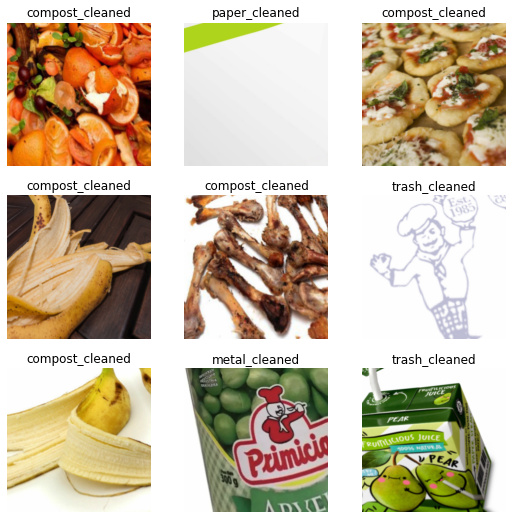

In [64]:
data.train.show_batch()

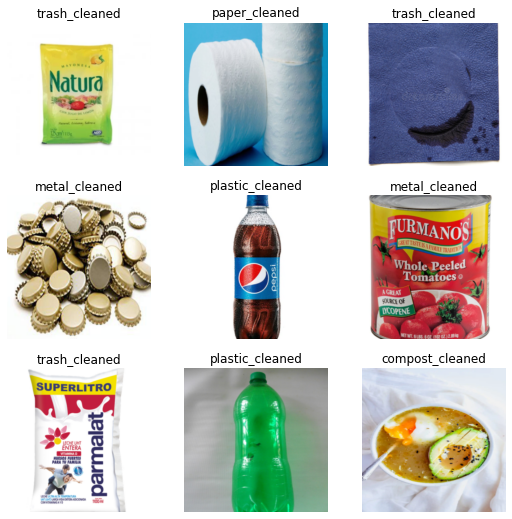

In [66]:
data.valid.show_batch()

In [67]:
data.vocab

['cardboard_cleaned', 'compost_cleaned', 'glass_cleaned', 'metal_cleaned', 'paper_cleaned', 'plastic_cleaned', 'trash_cleaned']

## Train the model using resnet50

In [68]:
learn = cnn_learner(data, resnet50, metrics=accuracy)

In [166]:
#learn.fine_tune(20)
learn.fit(n_epoch=50, lr=1e-7, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))

epoch,train_loss,valid_loss,accuracy,time
0,0.167376,0.333332,0.912162,25:52
1,0.164183,0.343385,0.905405,19:42
2,0.186446,0.353555,0.895270,30:50


No improvement since epoch 0: early stopping


In [70]:
learn.export(fname=f'{BASE_DIR}/version4epochs-resnet50.pkl')

In [71]:
learn_loaded = load_learner(f'{BASE_DIR}/version4epochs-resnet50.pkl')

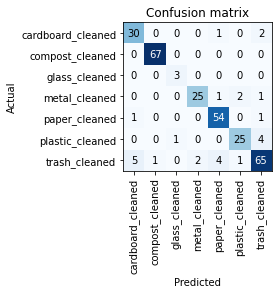

In [73]:
interep = ClassificationInterpretation.from_learner(learn)
interep.plot_confusion_matrix()

In [81]:
def get_predictions(learn_object, TEST_FOLDER):
    return list(map(lambda x: (x, learn_object.predict(f"{TEST_FOLDER}/{x}")[0]), listdir(TEST_FOLDER)))


In [82]:
preds = get_predictions(learn_loaded, TEST_PHOTOS_DIR)
for p in preds:
    print(p[0], '-----', p[1])
    

cascara-banana.jpeg ----- compost_cleaned
botella-plastico.jpeg ----- plastic_cleaned
cascaras-fruta.jpeg ----- compost_cleaned
basura-envase-plastico.jpeg ----- trash_cleaned
envase-plastico2.jpeg ----- plastic_cleaned
lata2.jpeg ----- metal_cleaned
papel.jpeg ----- paper_cleaned
papel-sucio.jpeg ----- compost_cleaned
sobre-de-te.jpeg ----- paper_cleaned
basura-vaso-plastico.jpeg ----- trash_cleaned
manzana-mordida.jpeg ----- compost_cleaned
basura1-metal.jpeg ----- trash_cleaned
tapa-plastico.jpeg ----- trash_cleaned
envase-plastico.jpeg ----- trash_cleaned
banana.jpg ----- compost_cleaned
cascara-banana3.jpeg ----- compost_cleaned
lata.jpeg ----- metal_cleaned
cascara-banana2.jpeg ----- compost_cleaned


In [97]:
data = ImageDataLoaders.from_folder(
    DATASET_DIR,
    train ='test',
    shuffle=True,
    item_tfms =[ToTensor,RandomResizedCrop(255, min_scale=0.35)],
    batch_tfms=aug_transforms()
)


In [90]:
listdir(f"{DATASET_DIR}/test")

['compost_cleaned',
 'cardboard_cleaned',
 'trash_cleaned',
 'paper_cleaned',
 'metal_cleaned',
 'glass_cleaned',
 'plastic_cleaned']

In [127]:
preds = []
actuals = []
for c in listdir(f"{DATASET_DIR}/test"):
    predictions = get_predictions(learn_loaded, f"{DATASET_DIR}/test/{c}")
    preds.extend(predictions)
    actuals.extend(np.full((1,len(predictions)), c).ravel().tolist())

In [131]:
pred_vals = list(map(lambda x : x[1], preds))

In [150]:
from sklearn.metrics import classification_report,accuracy_score, f1_score
print('Accuracy', accuracy_score(actuals, pred_vals))
print('F1 score', f1_score(actuals, pred_vals, average='macro'))
print(classification_report(y_pred=actuals, y_true=pred_vals))

Accuracy 0.9681208053691275
F1 score 0.9680249853587275
                   precision    recall  f1-score   support

cardboard_cleaned       0.99      0.96      0.98        83
  compost_cleaned       1.00      1.00      1.00       154
    glass_cleaned       1.00      1.00      1.00        10
    metal_cleaned       0.93      0.95      0.94        58
    paper_cleaned       0.96      0.98      0.97       109
  plastic_cleaned       0.94      0.96      0.95        47
    trash_cleaned       0.95      0.93      0.94       135

         accuracy                           0.97       596
        macro avg       0.97      0.97      0.97       596
     weighted avg       0.97      0.97      0.97       596



In [152]:
classes = list(map(lambda x: x.split('_')[0],listdir(f"{DATASET_DIR}/test")))

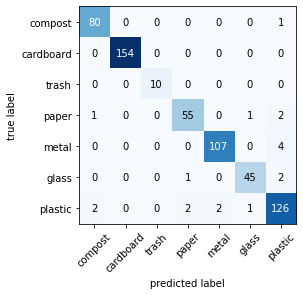

In [153]:
!pip install mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=classes)
plt.show()